In [6]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
#Gradient engine
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



In [8]:
#For Visualising nodes and operations performed
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) 
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad)
        dot.node(name=uid, label=label, shape='record')
        
        # Only create an operation node if _op is not None
        if n._op and n._op.strip():
            op_id = uid + n._op  # Unique ID for operation node
            dot.node(name=op_id, label=n._op, shape='circle')  # Circular operation node
            dot.edge(op_id, uid)  # Connect operation node to value node
    
    for n1, n2 in edges:
        if n2._op and n2._op.strip():  # Only connect to operation node if it exists
            dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        else:
            dot.edge(str(id(n1)), str(id(n2)))  # Direct connection if no operation node
    
    return dot



In [40]:
#Creating Neuron Class

class Neuron:

    def __init__(self,nn):
        self.w = [Value(random.uniform(-1,1)) for _ in range (nn)]
        self.b = Value (random.uniform(-1,1))

    def __call__(self, x):
        # w*x+b
        act = sum((wi*xi for wi, xi in zip(self.w,x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nn, nout):
        self.neurons= [ Neuron(nn) for _ in range (nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self, nn , nouts):
        sz = [nn]+ nouts
        self.layers = [Layer(sz[i], sz[i+1]) for  i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [ p for layer in self.layers for p in layer.parameters()]
        
    

In [41]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [42]:
x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=0.21789547988451627)

In [45]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.01 * p.grad
  
  print('epochs =', k, 'loss = ' ,loss.data)

epochs = 0 loss =  0.14401882415245057
epochs = 1 loss =  0.13935886223728952
epochs = 2 loss =  0.13496607657082949
epochs = 3 loss =  0.13081922902676948
epochs = 4 loss =  0.12689919666065755
epochs = 5 loss =  0.12318872214344462
epochs = 6 loss =  0.11967219785324743
epochs = 7 loss =  0.11633547856520685
epochs = 8 loss =  0.11316571851147675
epochs = 9 loss =  0.11015122926805979
epochs = 10 loss =  0.10728135549023561
epochs = 11 loss =  0.10454636598598775
epochs = 12 loss =  0.10193735800502432
epochs = 13 loss =  0.09944617294416835
epochs = 14 loss =  0.09706532193969201
epochs = 15 loss =  0.09478792004305485
epochs = 16 loss =  0.0926076278661355
epochs = 17 loss =  0.09051859974167925
epochs = 18 loss =  0.08851543757940739
epochs = 19 loss =  0.08659314971224982


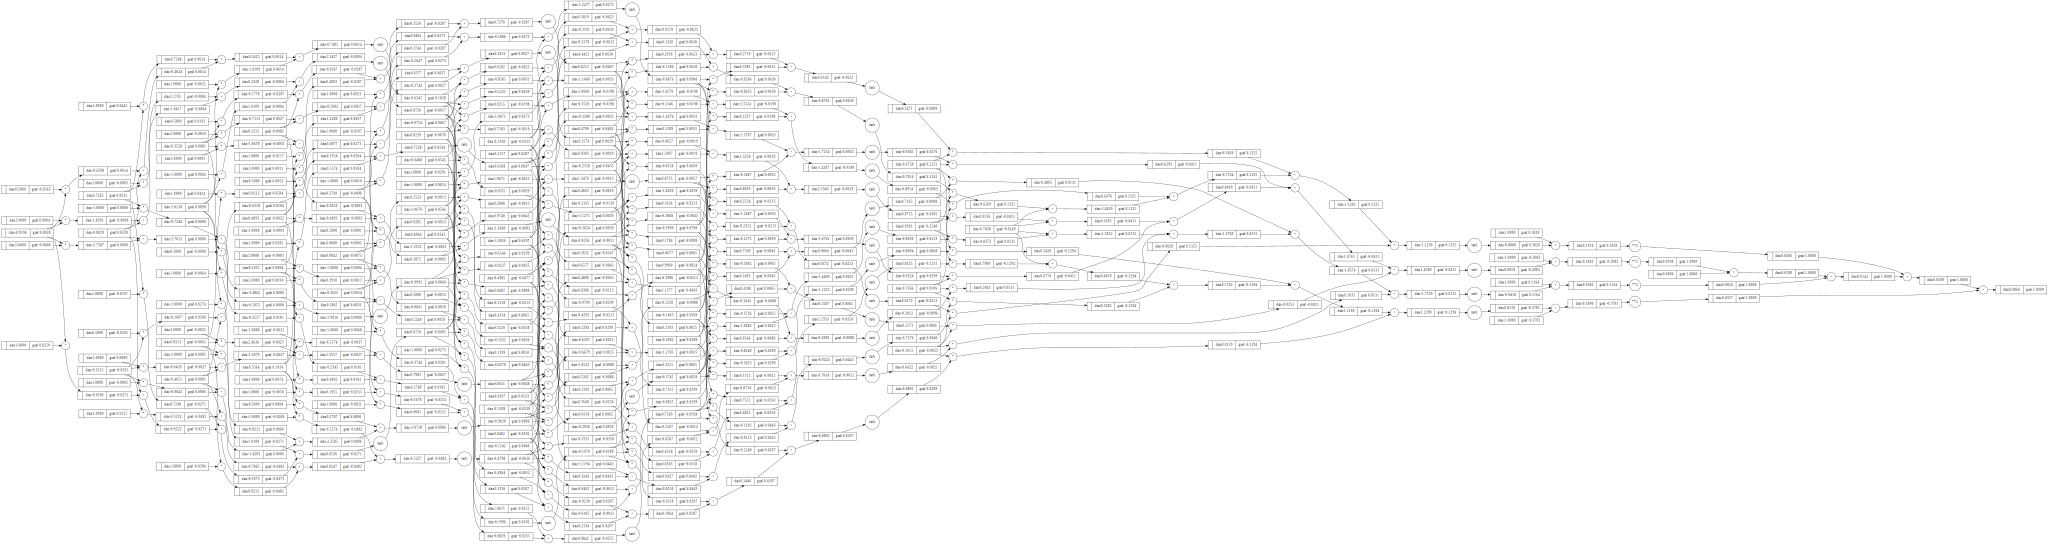

In [48]:
draw_dot(loss)